In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
df=pd.read_csv('/content/drive/MyDrive/DS/AT_Analysis/HVAC_Analysis/HVAC_Analysis_Latest/raw_data/Hvac_&_Energy_Combined.csv',index_col='time')

In [12]:
df.drop(df.iloc[:, :-10], axis = 1,inplace=True)

In [13]:
df.index = pd.to_datetime(df.index)

In [14]:
df.drop(df.iloc[:, 1:], axis = 1,inplace=True)

In [15]:
df

,HVAC Delta_T
time,
2022-03-10 00:00:00,12.6
2022-03-10 00:01:00,12.5
2022-03-10 00:02:00,12.5
2022-03-10 00:03:00,12.6
2022-03-10 00:04:00,12.6
...,...
2022-06-02 06:39:00,6.5
2022-06-02 06:40:00,6.5
2022-06-02 06:41:00,6.5


In [16]:
df.rename(columns = {'HVAC Delta_T':'Delta_t'}, inplace = True)

In [17]:
df = df.resample('1H').mean()

In [34]:
train, test = df[:-int(0.2*len(df))], df[-int(0.2*len(df)):] #80% training and 20% testing 

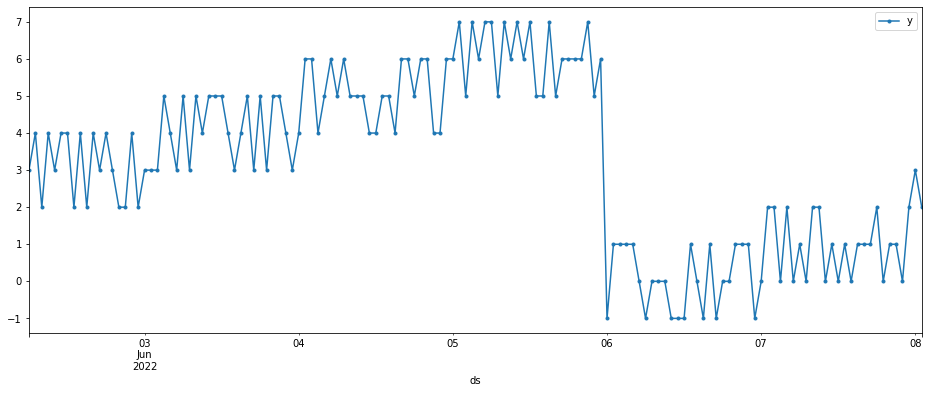

In [18]:
rng = np.random.RandomState(90)
serie_length = 7 * 20
dates = pd.date_range(df.index[-1], freq='H', periods=serie_length, name='ds')
y = dates.dayofweek + rng.randint(-1, 2, size=dates.size)
data = pd.DataFrame({'y': y.astype(np.float64)}, index=dates)
data.plot(marker='.', figsize=(16, 6));

In [19]:
valid_horizon = 14
train = data.head(-valid_horizon).copy()
y_valid = data.tail(valid_horizon)['y']

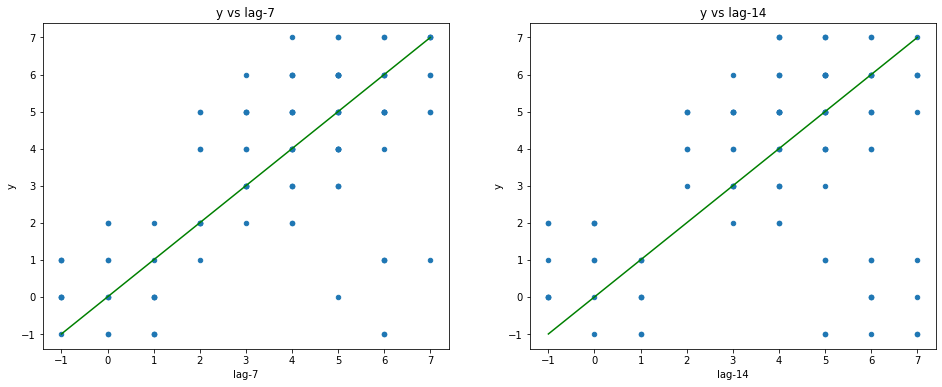

In [20]:
train['lag-7'] = train['y'].shift(7)
train['lag-14'] = train['y'].shift(14)

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

for lag, axi in zip((7, 14), ax.flat):
    train.plot.scatter(x=f'lag-{lag}', y='y', ax=axi)
    axi.plot([-1, 7], [-1, 7], c='g')
    axi.set_title(f'y vs lag-{lag}')

In [21]:
train.isnull().sum()


y          0
lag-7      7
lag-14    14
dtype: int64

In [22]:
train_without_nulls = train.dropna()
X_train = train_without_nulls.drop(columns='y')
y_train = train_without_nulls['y']

In [23]:
lr = LinearRegression(fit_intercept=False).fit(X_train, y_train)
lr.coef_

array([0.81013736, 0.07896845])

In [24]:

next_lags_7 = y_train.tail(7).values
next_lags_7

array([0., 1., 0., 2., 2., 0., 1.])

In [25]:
next_lags_14 = y_train.tail(14).values
next_lags_14

array([ 1., -1.,  0.,  2.,  2.,  0.,  2.,  0.,  1.,  0.,  2.,  2.,  0.,
        1.])

In [26]:
X_valid1 = pd.DataFrame({
    'lag-7': next_lags_7,
    'lag-14': next_lags_14[:7],
})
X_valid1

,lag-7,lag-14
0,0.0,1.0
1,1.0,-1.0
2,0.0,0.0
3,2.0,2.0
4,2.0,2.0
5,0.0,0.0
6,1.0,2.0


In [27]:

forecasts_7 = lr.predict(X_valid1)
forecasts_7

array([0.07896845, 0.73116891, 0.        , 1.77821161, 1.77821161,
       0.        , 0.96807425])

In [28]:
X_valid2 = pd.DataFrame({
    'lag-7': forecasts_7,
    'lag-14': next_lags_14[-7:],
})
X_valid2

,lag-7,lag-14
0,0.078968,0.0
1,0.731169,1.0
2,0.000000,0.0
3,1.778212,2.0
4,1.778212,2.0
5,0.000000,0.0
6,0.968074,1.0


In [29]:
forecasts_7_14 = lr.predict(X_valid2)
y_pred = np.hstack([forecasts_7, forecasts_7_14])
y_pred

array([0.07896845, 0.73116891, 0.        , 1.77821161, 1.77821161,
       0.        , 0.96807425, 0.06397529, 0.67131569, 0.        ,
       1.59853254, 1.59853254, 0.        , 0.86324156])

In [31]:
train_mlfcst = train.reset_index()[['ds', 'y']]
train_mlfcst.index = pd.Index(np.repeat(0, train.shape[0]), name='unique_id')
train_mlfcst

,ds,y
unique_id,,
0,2022-06-02 06:00:00,3.0
0,2022-06-02 07:00:00,4.0
0,2022-06-02 08:00:00,2.0
0,2022-06-02 09:00:00,4.0
0,2022-06-02 10:00:00,3.0
...,...,...
0,2022-06-07 07:00:00,0.0
0,2022-06-07 08:00:00,2.0
0,2022-06-07 09:00:00,2.0


In [ ]:
!pip install mlforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from mlforecast.core import TimeSeries
from mlforecast.forecast import Forecast

In [ ]:

ts = TimeSeries(lags=[7, 14])
ts

TimeSeries(freq=<Day>, transforms=['lag-7', 'lag-14'], date_features=[], num_threads=1)

In [ ]:
model = LinearRegression(fit_intercept=False)

In [ ]:
fcst = Forecast(model, ts)
fcst.fit(train_mlfcst)

Forecast(model=LinearRegression(fit_intercept=False), ts=TimeSeries(freq=<Day>, transforms=['lag-7', 'lag-14'], date_features=[], num_threads=1))

In [ ]:
y_pred_mlfcst = fcst.predict(14)
y_pred_mlfcst

,ds,y_pred
unique_id,,
0,2022-06-08 11:00:00,0.078968
0,2022-06-09 11:00:00,0.731169
0,2022-06-10 11:00:00,0.000000
0,2022-06-11 11:00:00,1.778212
0,2022-06-12 11:00:00,1.778212
0,2022-06-13 11:00:00,0.000000
0,2022-06-14 11:00:00,0.968074
0,2022-06-15 11:00:00,0.063975
0,2022-06-16 11:00:00,0.671316


In [41]:
df

,Delta_t
time,
2022-03-10 00:00:00,12.486667
2022-03-10 01:00:00,12.431667
2022-03-10 02:00:00,12.786667
2022-03-10 03:00:00,12.885000
2022-03-10 04:00:00,13.273333
...,...
2022-06-02 02:00:00,3.798246
2022-06-02 03:00:00,4.401667
2022-06-02 04:00:00,5.058333


In [64]:
import os
import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn import metrics

In [65]:
df2 = df.copy()


In [66]:
X = df2
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))


Observations: 2023
Training Observations: 1618
Testing Observations: 405


# xgb boost

In [67]:
import xgboost
from xgboost import XGBRegressor


import matplotlib.pyplot as plt
from xgboost import plot_importance
## Creating Features
def create_features(df, target_variable):
    
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if target_variable:
        y = df['Delta_t']
        return X, y
    return X

## METRICS

def mean_absolute_percentage_error(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def timeseries_evaluation_metrics_func(y_true, y_pred):
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

train_copy = train.copy()
test_copy = test.copy()

trainX, trainY = create_features(train_copy, target_variable='Delta_t')
testX, testY = create_features(test_copy, target_variable='Delta_t')

xgb = XGBRegressor(objective= 'reg:linear', n_estimators=1000)
xgb

xgb.fit(trainX, trainY,
        eval_set=[(trainX, trainY), (testX, testY)],
        early_stopping_rounds=50,
        verbose=False)


# Predictions 

[11:04:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


XGBRegressor(n_estimators=1000)

MSE is : 9.180281963652472
MAE is : 2.432563415534663
RMSE is : 3.0298980120876133
MAPE is : 86.1846810399048
R2 is : -0.029464546561597693



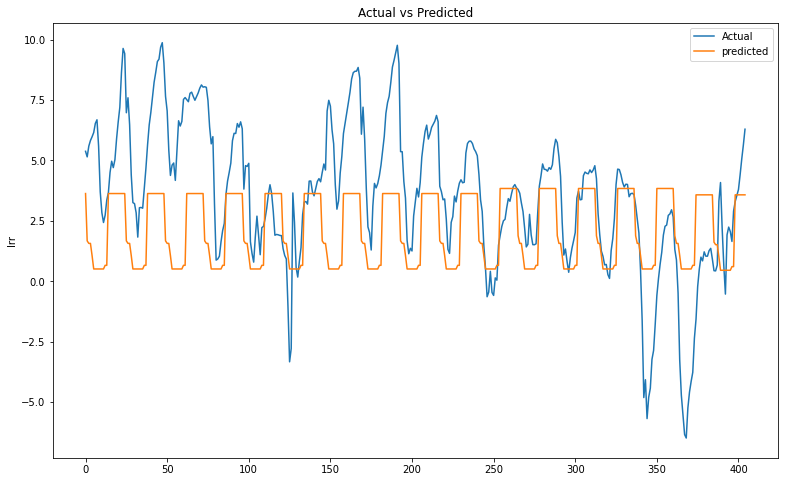

In [68]:
# Predictions 
predicted_results = xgb.predict(testX)

# Metrics
timeseries_evaluation_metrics_func(testY, predicted_results)

# Plotting graph for test and Predicted
plt.figure(figsize=(13,8))
plt.plot(list(testY))
plt.plot(list(predicted_results))
plt.title("Actual vs Predicted")
plt.ylabel("Irr")
plt.legend(('Actual','predicted'))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


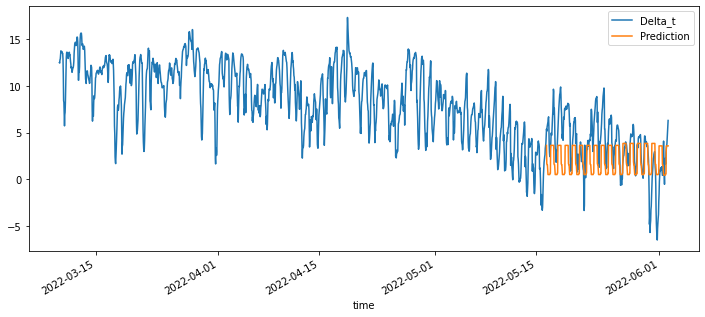

In [69]:
# Making graph of predicted on the whole dataframe
test['Prediction'] = predicted_results
Irr_all = pd.concat([test, train], sort=False)
Irr_all = Irr_all.rename(columns={'Irradiation':'Original_Value'})

Overview_Complete_Data_And_Prediction = Irr_all[['Delta_t','Prediction']].plot(figsize=(12, 5))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


[11:04:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


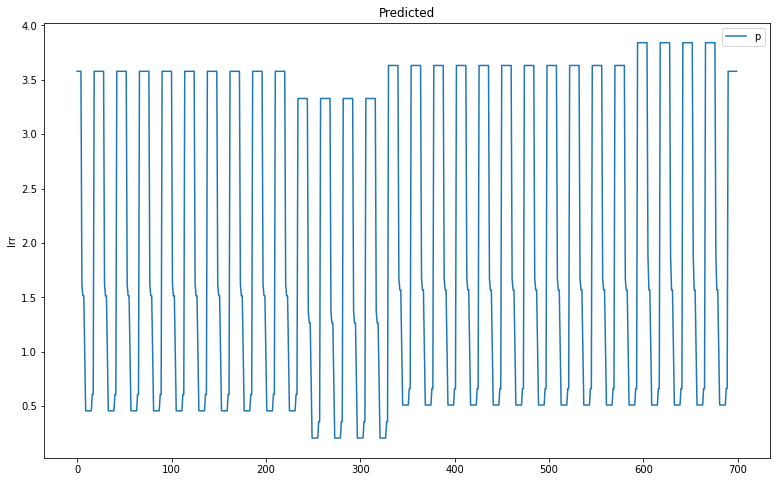

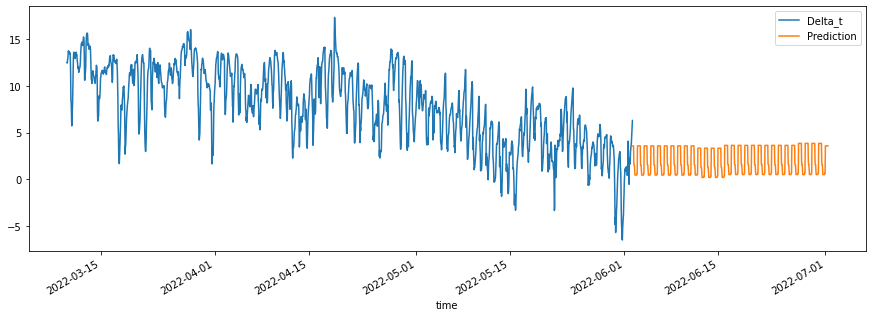

In [70]:
dti = pd.date_range(df.index[-1], periods=700, freq="H")
df_future_dates = pd.DataFrame(dti, columns = ['time'])
df_future_dates['Delta_t'] = np.nan
df_future_dates.index = pd.to_datetime(df_future_dates['time'], format='%Y-%m-%d %H:%M:%S')
df_future_dates_copy = df_future_dates.copy()
testX_future, testY_future = create_features(df_future_dates, target_variable='Delta_t')

xgb = XGBRegressor(objective= 'reg:linear', n_estimators=1000)
xgb

## Now here I have used train and test from above
xgb.fit(trainX, trainY,
        eval_set=[(trainX, trainY), (testX, testY)],
        early_stopping_rounds=50,
        verbose=False) 

predicted_results_future = xgb.predict(testX_future)

# Graph 
plt.figure(figsize=(13,8))
plt.plot(list(predicted_results_future))
plt.title("Predicted")
plt.ylabel("Irr")
plt.legend(('predicted'))
plt.show()

df_future_dates_copy['Prediction'] = predicted_results_future
Irr_all_future = pd.concat([df2, df_future_dates_copy], sort=False)

# Future Graph 
Overview_Complete_Data_And_Prediction_future = Irr_all_future[['Delta_t','Prediction']].plot(figsize=(15, 5))


# Linear Regression

In [71]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()

In [74]:
lr_model.fit(trainX, trainY)

LinearRegression()

MSE is : 6.388627024976287
MAE is : 1.9364848346391041
RMSE is : 2.527573347101185
MAPE is : 99.44025446799819
R2 is : 0.2835879061821641



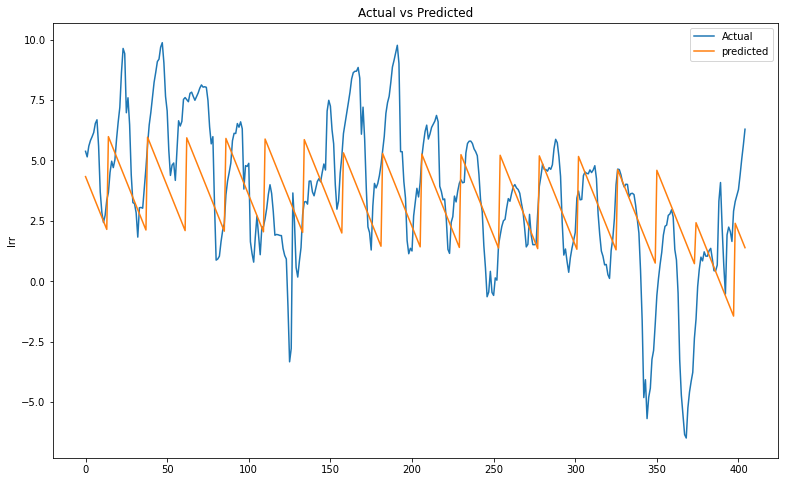

In [78]:
# Predictions 
predicted_results = lr_model.predict(testX)

# Metrics
timeseries_evaluation_metrics_func(testY, predicted_results)

# Plotting graph for test and Predicted
plt.figure(figsize=(13,8))
plt.plot(list(testY))
plt.plot(list(predicted_results))
plt.title("Actual vs Predicted")
plt.ylabel("Irr")
plt.legend(('Actual','predicted'))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


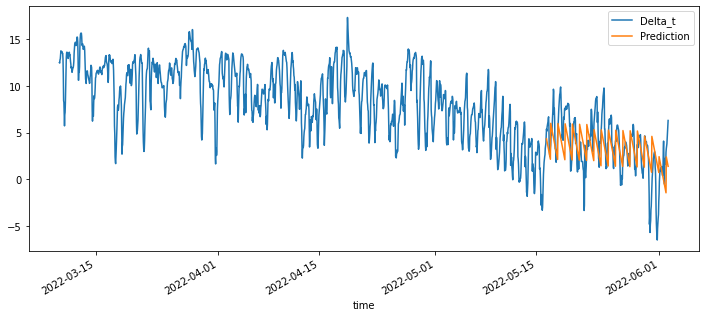

In [79]:
# Making graph of predicted on the whole dataframe
test['Prediction'] = predicted_results
Irr_all = pd.concat([test, train], sort=False)
Irr_all = Irr_all.rename(columns={'Irradiation':'Original_Value'})

Overview_Complete_Data_And_Prediction = Irr_all[['Delta_t','Prediction']].plot(figsize=(12, 5))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


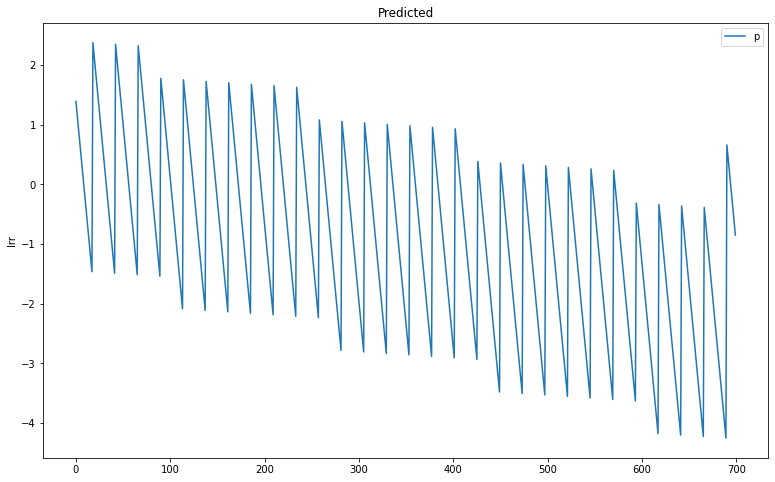

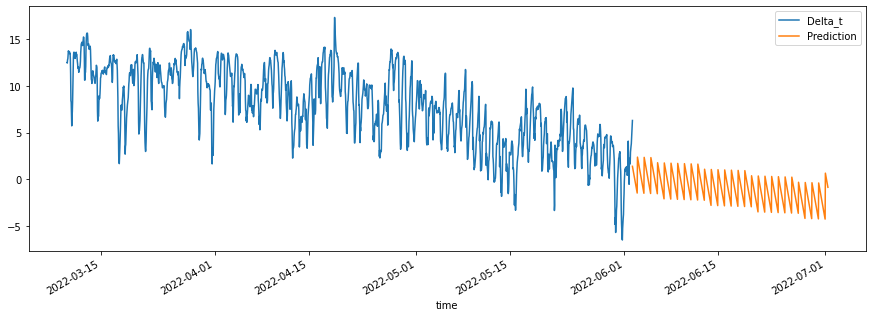

In [83]:
dti = pd.date_range(df.index[-1], periods=700, freq="H")
df_future_dates = pd.DataFrame(dti, columns = ['time'])
df_future_dates['Delta_t'] = np.nan
df_future_dates.index = pd.to_datetime(df_future_dates['time'], format='%Y-%m-%d %H:%M:%S')
df_future_dates_copy = df_future_dates.copy()
testX_future, testY_future = create_features(df_future_dates, target_variable='Delta_t')
lr_model = LinearRegression()
lr_model.fit(trainX, trainY)



predicted_results_future = lr_model.predict(testX_future)

# Graph 
plt.figure(figsize=(13,8))
plt.plot(list(predicted_results_future))
plt.title("Predicted")
plt.ylabel("Irr")
plt.legend(('predicted'))
plt.show()

df_future_dates_copy['Prediction'] = predicted_results_future
Irr_all_future = pd.concat([df2, df_future_dates_copy], sort=False)

# Future Graph 
Overview_Complete_Data_And_Prediction_future = Irr_all_future[['Delta_t','Prediction']].plot(figsize=(15, 5))


In [85]:
Irr_all_future.tail()

,Delta_t,time,Prediction
time,,,
2022-07-01 05:00:00,NaN,2022-07-01 05:00:00,-0.179135
2022-07-01 06:00:00,NaN,2022-07-01 06:00:00,-0.347180
2022-07-01 07:00:00,NaN,2022-07-01 07:00:00,-0.515225
2022-07-01 08:00:00,NaN,2022-07-01 08:00:00,-0.683270
2022-07-01 09:00:00,NaN,2022-07-01 09:00:00,-0.851315
